# Predict female walking speed from single NA neurons

In [1]:
%matplotlib inline
from itertools import product as cproduct
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
from sklearn import linear_model
import sys

import warnings
warnings.filterwarnings("ignore")

from disp import set_plot
from my_torch import skl_fit_lin_single
from record_0_main import smlt_ma

cc = np.concatenate

STRAINS = ['NM91', 'ZH23']
STRAIN_KEY = '_'.join(STRAINS).lower()

PTRAIN = .8
NSPLIT = 30

TARG_BHV = 'MTN'
TWDWS = [.03, 1, 60]
TARGS = [f'{TARG_BHV}_MN_{twdw}' for twdw in TWDWS]

FPS = 30.03  # sampling rate of behavioral data
DT = 1/FPS

STRAINS = ['NM91', 'ZH23']
STRAIN_KEY = '_'.join(STRAINS).lower()

FSTRAIN = 'data/simple/strains.csv'
MSTRAINS = [(pd.read_csv(FSTRAIN)['STRAIN'] == strain) for strain in STRAINS]
MSTRAIN = np.any(MSTRAINS, axis=0)
ISTRAIN = MSTRAIN.nonzero()[0]

PFX_NRL = f'data/simple/mlv/ma_built/nrl/ma_built'

MASK_PFX = 'data/simple/masks/mask'

In [2]:
PFX_BHV = f'data/simple/behav_xtd/behav_xtd'

NTR = len(ISTRAIN)
NTRAIN = int(round(PTRAIN*NTR))

In [3]:
# neural params
TAU_R = np.array([.1, .5, 1, 2, 5, 10, 30, 60, 120, 180, 240, 480, 600])
TAU_A = np.array([.1, .5, 1, 2, 5, 10, 30, 60, np.inf])
X_S = np.array([0, .5, 1])

tau_r_tau_a_x_s = np.array(list(cproduct(TAU_R, TAU_A, X_S)))

tau_rs = tau_r_tau_a_x_s[:, 0]
tau_as = tau_r_tau_a_x_s[:, 1]
x_ss = tau_r_tau_a_x_s[:, 2]
x_ps = 1 - x_ss  # pulse selectivity

nr = len(tau_rs)

r_cols = [f'R_{ir}' for ir in range(nr)]

In [4]:
FSAVE = f'data/simple/mlv/ma_built/ma_built_nrl_single_{STRAIN_KEY}_{TARG_BHV.lower()}.npy'

## Fit model

In [5]:
rslt = skl_fit_lin_single(
    pfxs=[PFX_NRL, PFX_BHV],
    cols_x=r_cols,
    targs=TARGS,
    itr_all=ISTRAIN,
    ntrain=NTRAIN,
    nsplit=NSPLIT,
    mask_pfx=MASK_PFX)

# save results
save_data = {
    'r2_train': rslt.r2_train,
    'r2_test': rslt.r2_test,

    'w': rslt.w,
    'bias': rslt.bias,

    'targs': TARGS,

    'ntr': NTR,
    'ntrain': NTRAIN,
    'nsplit': NSPLIT
}

np.save(FSAVE, np.array([save_data]))

Splits:


Save single-neuron variance explained

In [13]:
data = np.load(FSAVE, allow_pickle=True)[0]

resave_dict = {'TAU_R': tau_rs, 'TAU_A': tau_as, 'X_S': x_ss, 'X_P': x_ps, 'r2_test': {}}

for targ in TARGS:
    resave_dict['r2_test'][targ] = data['r2_test'][targ].mean(axis=0)
    
np.save(f'data/simple/mlv/ma_built/ma_built_nrl_single_{STRAIN_KEY}_r2.npy', np.array([resave_dict]))

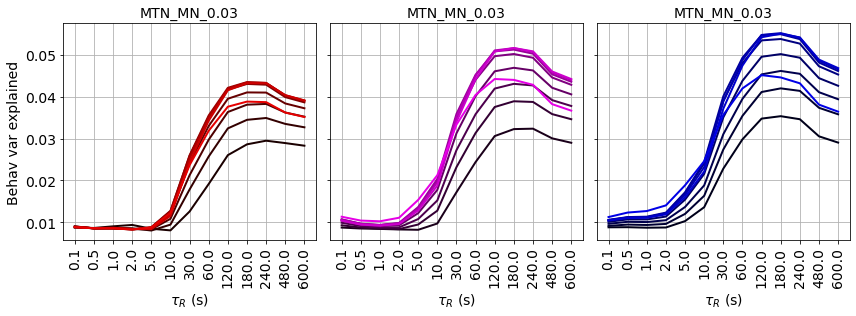

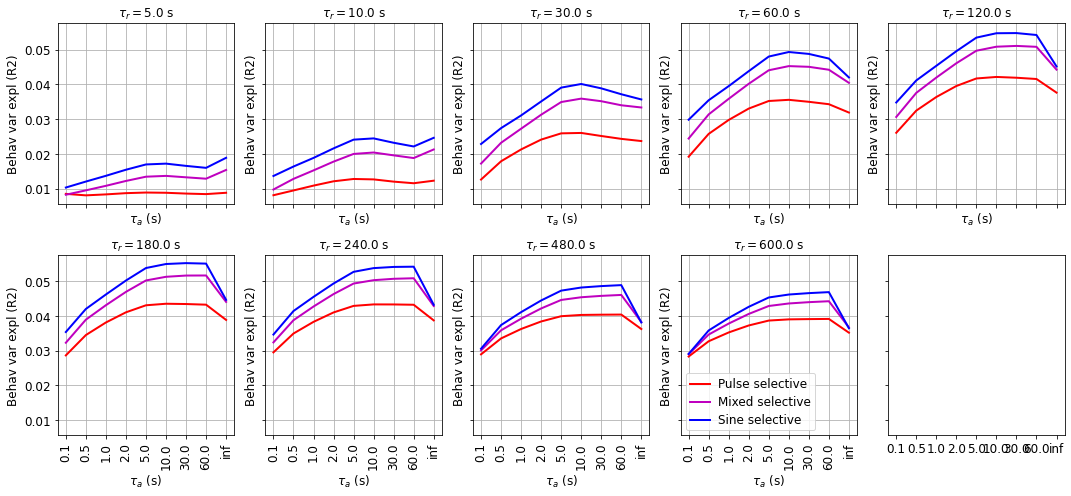

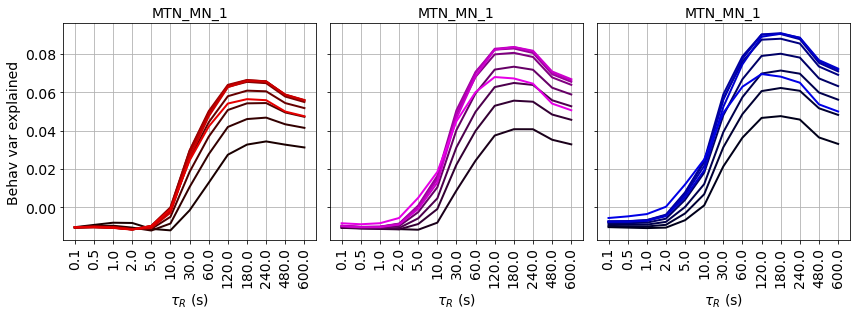

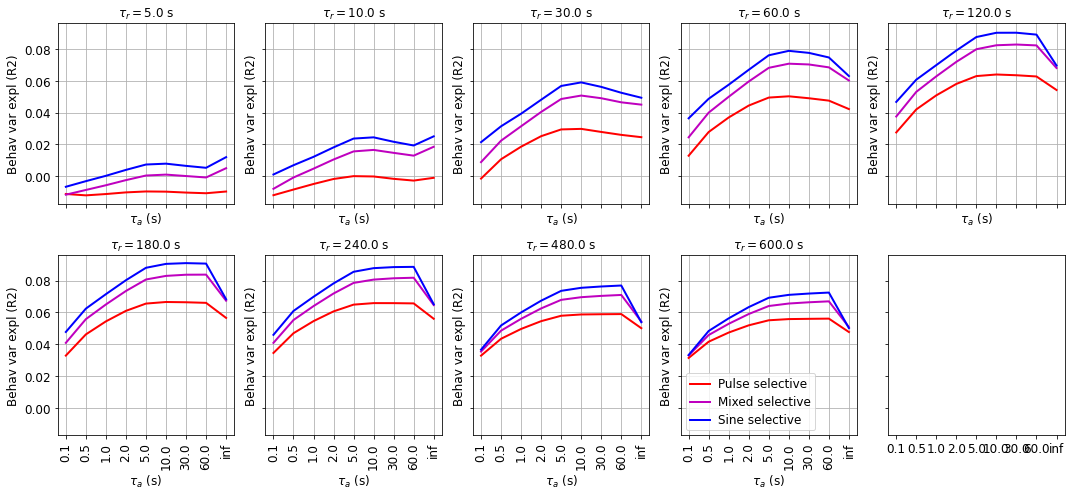

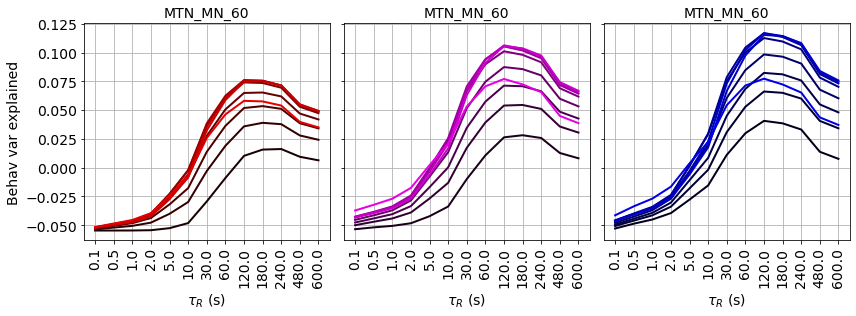

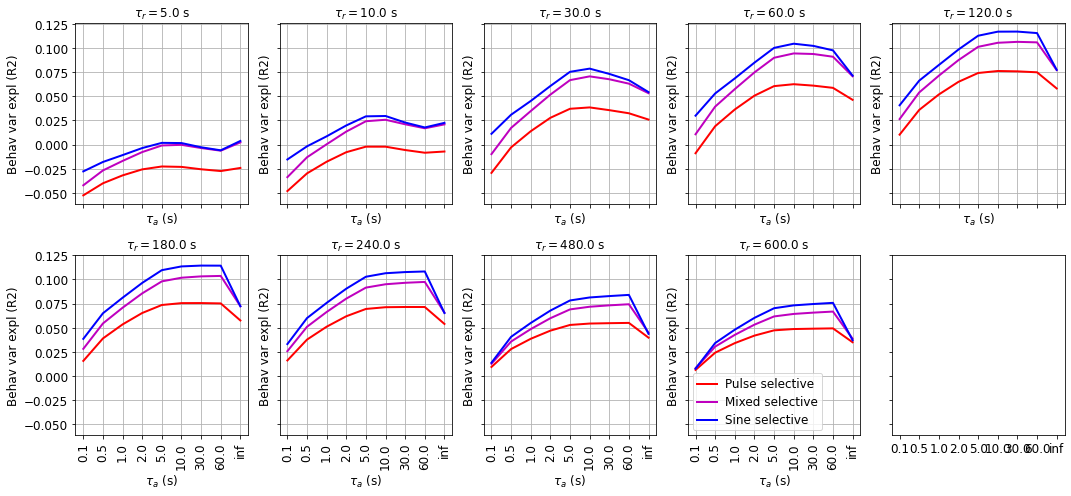

In [12]:
for targ in TARGS:
    r2s = data['r2_test'][targ].mean(axis=0)  # avg R2 for all model neurons in MA-built ppln
    
    # plot R2 vs tau_r, tau_a, and selectivity
    fig, axs = plt.subplots(1, 3, figsize=(12, 4.5), tight_layout=True, sharex=True, sharey=True)
    colors = [np.array([1, 0, 0]), np.array([1, 0, 1]), np.array([0, 0, 1])]

    for ax, c, x_s in zip(axs, colors, X_S):
        mx_s = np.isclose(x_ss, x_s)
        # loop over adaptation rates
        for ctau_a, tau_a in enumerate(TAU_A):
            if ~np.isinf(tau_a):
                mtau_a = np.isclose(tau_as, tau_a)
            else:
                mtau_a = np.isinf(tau_as)

            # get tau_rs and  of neurons with this x_s and tau_a
            tau_rs_ = tau_rs[mx_s & mtau_a]
            r2s_ = r2s[mx_s & mtau_a]

            color = c*(.1 + (1-.1)*ctau_a/len(TAU_A))
            ax.plot(np.arange(len(TAU_R)), r2s_, lw=2, c=color)

        ax.set_xticks(np.arange(len(TAU_R)))
        ax.set_xticklabels([f'{tau_r:.1f}' for tau_r in TAU_R], rotation=90)
        ax.set_xlabel(r'$\tau_R$ (s)')
        ax.set_title(f'x_s = {x_s}')

    axs[0].set_ylabel('Behav var explained')
    for ax in axs:
        set_plot(ax, title=f'{targ}', font_size=14)
#         ax.legend([r'$\tau_a = $' + f'{tau_a:.3f}' for tau_a in TAU_A], ncol=2, fontsize=12)
        ax.grid()

    # plot R2 vs TAU_A for several different TAU_R
    ntau_r = 9
    colors = ['r', 'm', 'b']

    fig, axs = plt.subplots(2, 5, figsize=(15, 7), tight_layout=True, sharex=True, sharey=True)
    axs = axs.flatten()

    for cax, (ax, tau_r) in enumerate(zip(axs, TAU_R[-ntau_r:])):
        mtau_r = np.isclose(tau_rs, tau_r)
        for x_s, c in zip(X_S, colors):
            mx_s = np.isclose(x_ss, x_s)
            # get tau_as and R2s of responses w/ this tau_r and x_s
            tau_as_ = tau_as[mtau_r & mx_s]
            r2s_ = r2s[mtau_r & mx_s]

            assert list(tau_as_) == sorted(tau_as_)

            ax.plot(np.arange(len(TAU_A)), r2s_, lw=2, c=c)

        ax.set_xticks(np.arange(len(TAU_A)))
        ax.set_xticklabels([f'{tau_a}' for tau_a in TAU_A], rotation=90)
        ax.set_xlabel(r'$\tau_a$ (s)')
        ax.set_ylabel('Behav var expl (R2)')
        ax.set_title(r'$\tau_r =$' + f'{tau_r} s')
        ax.grid()

    ax.legend(['Pulse selective', 'Mixed selective', 'Sine selective'])

    for ax in axs:
        set_plot(ax, font_size=12)